<h1>Preprocessing</h1>

In [1]:
import pandas as pd
import numpy as np

from mlxtend.evaluate import paired_ttest_5x2cv

import matplotlib.pyplot as plt

import warnings

import seaborn as sn

import warnings

from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn import metrics 
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

warnings.filterwarnings('ignore')

#Reading data
df2014=pd.read_csv("../2014_Financial_Data.csv")
df2015=pd.read_csv("../2015_Financial_Data.csv")
df2016=pd.read_csv("../2016_Financial_Data.csv")
df2017=pd.read_csv("../2017_Financial_Data.csv")
df2018=pd.read_csv("../2018_Financial_Data.csv")

#Changing column name for price variation into same name
df2014.rename(columns={"2015 PRICE VAR [%]": "PRICE VAR NEXT YEAR"},inplace=True)
df2015.rename(columns={"2016 PRICE VAR [%]": "PRICE VAR NEXT YEAR"},inplace=True)
df2016.rename(columns={"2017 PRICE VAR [%]": "PRICE VAR NEXT YEAR"},inplace=True)
df2017.rename(columns={"2018 PRICE VAR [%]": "PRICE VAR NEXT YEAR"},inplace=True)
df2018.rename(columns={"2019 PRICE VAR [%]": "PRICE VAR NEXT YEAR"},inplace=True)

#Adding year attribute for each csv file
df2014['Year']=2014
df2015['Year']=2015
df2016['Year']=2016
df2017['Year']=2017
df2018['Year']=2018

data = pd.concat([df2014 ,df2015, df2016, df2017, df2018])
data.rename(columns={'Unnamed: 0':'Stock'}, inplace=True)

print(len(df2018))
data.info()
data.head()

4392
<class 'pandas.core.frame.DataFrame'>
Int64Index: 22077 entries, 0 to 4391
Columns: 226 entries, Stock to Year
dtypes: float64(222), int64(2), object(2)
memory usage: 38.2+ MB


,Stock,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,PRICE VAR NEXT YEAR,Class,Year
0,PG,7.440100e+10,-0.0713,3.903000e+10,3.537100e+10,0.000000e+00,2.146100e+10,2.146100e+10,1.391000e+10,7.090000e+08,...,-0.0217,0.0359,0.0316,0.1228,0.0000,-0.1746,Consumer Defensive,-9.323276,0,2014
1,VIPS,3.734148e+09,1.1737,2.805625e+09,9.285226e+08,1.083303e+08,3.441414e+08,7.939267e+08,1.345959e+08,1.214869e+07,...,NaN,NaN,NaN,NaN,1.6484,1.7313,Consumer Defensive,-25.512193,0,2014
2,KR,9.837500e+10,0.0182,7.813800e+10,2.023700e+10,0.000000e+00,1.519600e+10,1.751200e+10,2.725000e+09,4.430000e+08,...,0.0981,0.1886,0.3268,0.2738,0.0000,0.0234,Consumer Defensive,33.118297,1,2014
3,RAD,2.552641e+10,0.0053,1.820268e+10,7.323734e+09,0.000000e+00,6.561162e+09,6.586482e+09,7.372520e+08,4.245910e+08,...,-0.0510,-0.0189,0.1963,-0.0458,0.0000,-0.0060,Consumer Defensive,2.752291,1,2014
4,GIS,1.790960e+10,0.0076,1.153980e+10,6.369800e+09,0.000000e+00,3.474300e+09,3.412400e+09,2.957400e+09,3.024000e+08,...,0.0090,0.0215,0.0274,0.1025,0.0000,-0.0220,Consumer Defensive,12.897715,1,2014


In [2]:
X=data
y=data["Class"]

X=X.drop("Stock",axis=1)
X=X.drop("PRICE VAR NEXT YEAR",axis=1)
X=X.drop("Class",axis=1)
X=X.drop("Year",axis=1)

<h3>Dropping attributes which frequently contain missing values</h3>

In [3]:
attributeNames=X.columns.tolist()
missingPercentage = X.isnull().sum() * 100 / len(X) # missing val % for each column
thresholdedAttribute=missingPercentage.where(missingPercentage>=33)
thresholdedAttribute=[attributeNames[a] for a in range(len(thresholdedAttribute)) if str(thresholdedAttribute[a]) != "nan"]
print(thresholdedAttribute,len(thresholdedAttribute))

['priceEarningsToGrowthRatio', 'ebtperEBIT', 'niperEBT', 'effectiveTaxRate', 'nIperEBT', 'eBTperEBIT', 'operatingCycle', 'cashConversionCycle', 'shortTermCoverageRatios', 'dividendPayoutRatio', 'Net Debt to EBITDA', '10Y Revenue Growth (per Share)', '10Y Operating CF Growth (per Share)', '10Y Net Income Growth (per Share)', '10Y Shareholders Equity Growth (per Share)', '10Y Dividend per Share Growth (per Share)'] 16


In [4]:
#drop the columns that has more than 33% missing values
print(X.shape)
X=X.drop(thresholdedAttribute,axis=1)
print(X.shape)
attributeNames=X.columns.tolist()
missingPercentage = X.isnull().sum() * 100 / len(X) # missing val % for each column

(22077, 222)
(22077, 206)


In [5]:
# Replace nan-values with mean value of column, considering each sector individually.
X = X.groupby(['Sector']).transform(lambda x: x.fillna(x.mean()))

<h1>1- Feature Selection Overview</h1>

**Mutual Information**

In [6]:
#https://medium.com/@hertan06/which-features-to-use-in-your-model-350630a1e31c
#We use Mutual Information...
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from prettytable import PrettyTable
t = PrettyTable(['Attribute', 'Score','Missing Values %'])
t.title = 'Results for Mutual Information'
threshold = 20  # the number of most relevant features
high_score_features = []

feature_scores = mutual_info_classif(X, y, random_state=0)
#feature_scores = f_classif(X, y)[0]
for score, f_name in sorted(zip(feature_scores, X.columns), reverse=True)[:threshold]:
        t.add_row([f_name, score, missingPercentage[attributeNames.index(f_name)]])
        high_score_features.append(f_name)
        
print(t)

+---------------------------------------------------------------------------+
|                       Results for Mutual Information                      |
+-------------------------------+----------------------+--------------------+
|           Attribute           |        Score         |  Missing Values %  |
+-------------------------------+----------------------+--------------------+
|    Total non-current assets   | 0.022112280957419017 | 27.27725687366943  |
|          EBIT Margin          | 0.022054091974503587 | 7.582551977170811  |
|         eBITperRevenue        | 0.01920992042646863  | 12.963717896453323 |
|          Gross Profit         | 0.019154132780264455 | 5.467228337183494  |
|          payoutRatio          | 0.018948078374790178 | 10.82574625175522  |
| Total non-current liabilities | 0.018644065311503644 | 27.340671286859628 |
|      Earnings before Tax      | 0.01823924284012657  | 6.178375685102142  |
|         ebitperRevenue        | 0.018153038022910906 | 12.9637

**Anova F-Value**

In [7]:
#https://medium.com/@hertan06/which-features-to-use-in-your-model-350630a1e31c
#We use ANOVA F-value...
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from prettytable import PrettyTable
t = PrettyTable(['Attribute', 'Score','Missing Values %'])
t.title = 'Results for ANOVA F-Value'
threshold = 20  # the number of most relevant features
high_score_features = []

#feature_scores = mutual_info_classif(X, y, random_state=0)
feature_scores = f_classif(X, y)[0]
for score, f_name in sorted(zip(feature_scores, X.columns), reverse=True)[:threshold]:
        t.add_row([f_name, score, missingPercentage[attributeNames.index(f_name)]])
        high_score_features.append(f_name)

X=X[high_score_features]
print(t)

+---------------------------------------------------------------------------+
|                         Results for ANOVA F-Value                         |
+---------------------------------+--------------------+--------------------+
|            Attribute            |       Score        |  Missing Values %  |
+---------------------------------+--------------------+--------------------+
|        Dividend payments        | 40.99933856904691  | 9.765819631290483  |
|           Gross Margin          | 32.31890334987439  | 5.4309915296462385 |
|       Earnings before Tax       | 31.54958855350051  | 6.178375685102142  |
|          Free Cash Flow         | 31.143068580384302 | 7.424015944195316  |
|         Operating Income        | 27.759629645131373 | 4.987090637314853  |
|     Stock-based compensation    | 27.303706581127024 | 7.849798432758074  |
|           SG&A Expense          | 23.464233709464327 | 7.5599039724600265 |
| Cash and short-term investments | 22.72453457323068  | 11.2107

<h3>Train-Test Split</h3>

In [8]:
# LAST YEAR==2018/LAST CSV IS OUR TEST SET THERE IS NO CROSS VALIDATION APPLIED

X_train=X[0:(len(X)-4392)]
X_test=X[(len(X)-4392):len(X)]
y_train=y[0:(len(X)-4392)]
y_test=y[(len(X)-4392):len(X)]

In [9]:
# Define the scaler 
scaler = StandardScaler().fit(X)

# Scale the train set
X_train = scaler.transform(X_train)

# Scale the test set
X_test = scaler.transform(X_test)

<h1>2- Classification Experiments</h1>

We did not use Cross Validation or any other methods like that.
We split our train and test set according to years.
Last years csv, 2018, is our test set.
And we use features selected in ANOVA F-Value.

In [10]:
def dfInsertRow(df,row):
    row_series = pd.Series(row, index = df.columns)
    df = df.append(row_series, ignore_index=True)
    return df

def Classification(classifier,X_train,y_train,X_test,y_test,classifierName): #Direct classification 
    clf = classifier.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    y_score= clf.predict_proba(X_test)
    y_score = y_score[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_score)
    return [classifierName,
           metrics.accuracy_score(y_test, y_pred),metrics.f1_score(y_test, y_pred,average="macro"),
           metrics.f1_score(y_test, y_pred,average="micro"),metrics.roc_auc_score(y_test,y_score),fpr,tpr,y_pred]
    
    
dfEvaluation  = pd.DataFrame(columns = ["Experiment", "Accuracy", "F1-macro", "F1-micro", "AUC","FPR","TPR","y_pred"]) 
dfROC = pd.DataFrame(columns=["Experiment", "AUC","FPR","TPR"])
dfConfusionMatrix = pd.DataFrame(columns=["Experiment", "Accuracy","y_pred"])

In [11]:
#dfEvaluation=dfInsertRow(dfEvaluation,CrossValidation(clfgini,X,y,"gini"))
#dfEvaluation=dfInsertRow(dfEvaluation,Bagging(clfgini,X_train,y_train,X_test,y_test,"gini"))
#dfEvaluation=dfInsertRow(dfEvaluation,Boosting(clfgini,X_train,y_train,X_test,y_test,"gini"))

**Decision Tree with Gini Index**

In [12]:
clfgini = DecisionTreeClassifier(criterion="gini")
dfEvaluation=dfInsertRow(dfEvaluation,Classification(clfgini,X_train,y_train,X_test,y_test,"Decision Tree with Gini Index"))

**Decision Tree with Gain Ratio**

In [13]:
clfgain = DecisionTreeClassifier(criterion="entropy")
dfEvaluation=dfInsertRow(dfEvaluation,Classification(clfgain,X_train,y_train,X_test,y_test,"Decision Tree with Gain Ratio"))

**Naïve Bayes**

In [14]:
clfGaussianNB = GaussianNB()
dfEvaluation=dfInsertRow(dfEvaluation,Classification(clfGaussianNB,X_train,y_train,X_test,y_test,"Naive Bayes"))

**Artificial neural networks with 1 hidden layer**

In [15]:
clfANN1=MLPClassifier(hidden_layer_sizes=(140,),random_state=1, max_iter=1000)
dfEvaluation=dfInsertRow(dfEvaluation,Classification(clfANN1,X_train,y_train,X_test,y_test,"ANN with 1 hidden layer"))

**Artificial neural networks with 1 hidden layer**

In [16]:
clfANN2=MLPClassifier(hidden_layer_sizes=(70,70,),random_state=1, max_iter=1000)
dfEvaluation=dfInsertRow(dfEvaluation,Classification(clfANN2,X_train,y_train,X_test,y_test,"ANN with 2 hidden layer"))

**k-NN, n_neighbors=3**

In [17]:
clfKNN5= KNeighborsClassifier(n_neighbors=3)
dfEvaluation=dfInsertRow(dfEvaluation,Classification(clfKNN5,X_train,y_train,X_test,y_test,"KNN 3"))

**k-NN, n_neighbors=9**

In [18]:
clfKNN15= KNeighborsClassifier(n_neighbors=9)
dfEvaluation=dfInsertRow(dfEvaluation,Classification(clfKNN15,X_train,y_train,X_test,y_test,"KNN 9"))

**k-NN, n_neighbors=149**

In [19]:
clfKNN25= KNeighborsClassifier(n_neighbors=149)
dfEvaluation=dfInsertRow(dfEvaluation,Classification(clfKNN25,X_train,y_train,X_test,y_test,"KNN 149"))

**Table for evaluation**

In [20]:
dfROC["Experiment"]=dfEvaluation["Experiment"]
dfROC["AUC"]=dfEvaluation["AUC"]
dfROC["FPR"]=dfEvaluation["FPR"]
dfROC["TPR"]=dfEvaluation["TPR"]
dfEvaluation=dfEvaluation.drop(["FPR","TPR"],axis=1)

dfConfusionMatrix["Experiment"]=dfEvaluation["Experiment"]
dfConfusionMatrix["Accuracy"]=dfEvaluation["Accuracy"]
dfConfusionMatrix["y_pred"]=dfEvaluation["y_pred"]
dfEvaluation=dfEvaluation.drop(["y_pred"],axis=1)

#TABLE
dfEvaluation.head(len(dfEvaluation))

,Experiment,Accuracy,F1-macro,F1-micro,AUC
0,Decision Tree with Gini Index,0.528916,0.510808,0.528916,0.534653
1,Decision Tree with Gain Ratio,0.521403,0.505316,0.521403,0.531224
2,Naive Bayes,0.670993,0.428472,0.670993,0.603608
3,ANN with 1 hidden layer,0.680328,0.629554,0.680328,0.682963
4,ANN with 2 hidden layer,0.561475,0.555338,0.561475,0.631891
5,KNN 3,0.570355,0.550413,0.570355,0.592899
6,KNN 9,0.602687,0.579037,0.602687,0.624357
7,KNN 149,0.665528,0.627639,0.665528,0.670177


<h1>3- ROC Curves</h1>

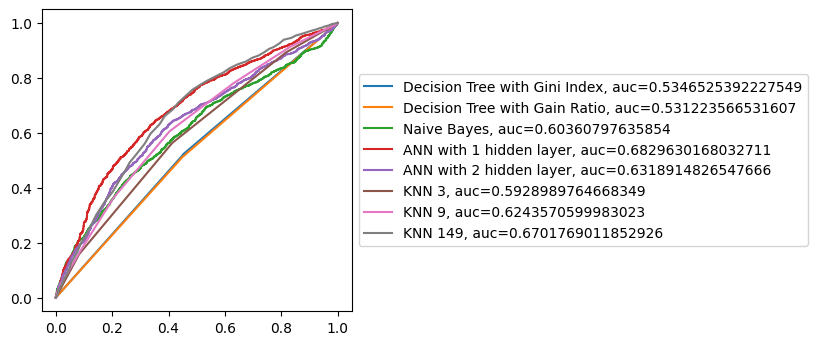

In [21]:
plt.figure(figsize=(4, 4), dpi=100).clf()
for i in range(len(dfROC)):
    plt.plot(dfROC["FPR"][i],dfROC["TPR"][i],label=str(dfROC["Experiment"][i])+", auc="+str(dfROC["AUC"][i]))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

<h1>4- Confusion Matrix</h1>

	Confusion Matrix for ANN with 1 hidden layer


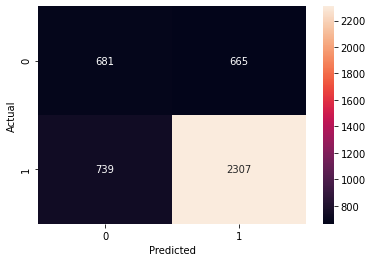

In [22]:
bestIndex=dfConfusionMatrix.Accuracy.idxmax()
print("\tConfusion Matrix for",dfConfusionMatrix["Experiment"][bestIndex])
data = {'y_test':    y_test,
        'y_pred': dfConfusionMatrix["y_pred"][bestIndex]
        }
dfCMplt = pd.DataFrame(data, columns=['y_test','y_pred'])
confusion_matrix = pd.crosstab(dfCMplt['y_test'], dfCMplt['y_pred'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True,fmt='g')
plt.show()

<h1>5- Statistical significance analysis between your best performing model and its closest competitor </h1>

In [28]:
#https://towardsdatascience.com/evaluate-ml-classifier-performance-using-statistical-hypothesis-testing-in-python-e4b90eb27dce
# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=clfANN1, 
                          estimator2=clfGaussianNB, 
                          X=X, 
                          y=y, 
                          scoring='accuracy'
                          )
# summarize
print(f'The P-value is = {p:.3f}')
print(f'The t-statistics is = {t:.3f}')
# interpret the result
if p <= 0.05:
    print('Since p<0.05, We can reject the null-hypothesis in terms of accuracy  that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.')
else:
    print('Since p>0.05, we cannot reject the null hypothesis in terms of accuracy and may conclude that the performance of the two algorithms is not significantly different.')

The P-value is = 0.002
The t-statistics is = 5.914
Since p<0.05, We can reject the null-hypothesis in terms of accuracy  that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.


In [29]:
#https://towardsdatascience.com/evaluate-ml-classifier-performance-using-statistical-hypothesis-testing-in-python-e4b90eb27dce
# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=clfANN1, 
                          estimator2=clfGaussianNB, 
                          X=X, 
                          y=y, 
                          scoring="f1_macro"
                          )
# summarize
print(f'The P-value is = {p:.3f}')
print(f'The t-statistics is = {t:.3f}')
# interpret the result
if p <= 0.05:
    print('Since p<0.05, We can reject the null-hypothesis in terms of f1_macro  that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.')
else:
    print('Since p>0.05, we cannot reject the null hypothesis in terms of f1_macro  and may conclude that the performance of the two algorithms is not significantly different.')

The P-value is = 0.005
The t-statistics is = 4.883
Since p<0.05, We can reject the null-hypothesis in terms of f1_macro  that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.


In [30]:
#https://towardsdatascience.com/evaluate-ml-classifier-performance-using-statistical-hypothesis-testing-in-python-e4b90eb27dce
# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=clfANN1, 
                          estimator2=clfGaussianNB, 
                          X=X, 
                          y=y, 
                          scoring="f1_micro"
                          )
# summarize
print(f'The P-value is = {p:.3f}')
print(f'The t-statistics is = {t:.3f}')
# interpret the result
if p <= 0.05:
    print('Since p<0.05, We can reject the null-hypothesis in terms of f1_micro that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.')
else:
    print('Since p>0.05, we cannot reject the null hypothesis in terms of  f1_micro may conclude that the performance of the two algorithms is not significantly different.')

The P-value is = 0.059
The t-statistics is = 2.428
Since p>0.05, we cannot reject the null hypothesis in terms of  f1_micro may conclude that the performance of the two algorithms is not significantly different.


In [32]:
#https://towardsdatascience.com/evaluate-ml-classifier-performance-using-statistical-hypothesis-testing-in-python-e4b90eb27dce
# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=clfANN1, 
                          estimator2=clfGaussianNB, 
                          X=X, 
                          y=y, 
                          scoring="roc_auc"
                          )
# summarize
print(f'The P-value is = {p:.3f}')
print(f'The t-statistics is = {t:.3f}')
# interpret the result
if p <= 0.05:
    print('Since p<0.05, We can reject the null-hypothesis in terms of AUC that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.')
else:
    print('Since p>0.05, we cannot reject the null hypothesis in terms of AUC and may conclude that the performance of the two algorithms is not significantly different.')

The P-value is = 0.398
The t-statistics is = -0.923
Since p>0.05, we cannot reject the null hypothesis in terms of AUC and may conclude that the performance of the two algorithms is not significantly different.
